## Signed Cumulative Distribution Transform Nearest Local Subspace (SCDT-NLS) Classifier

This tutorial will demonstrate how to use the SCDT-NLS classifier from the *PyTransKit* package to classify 1D signals.

## Class:: SCDT_NLS
**Functions**:

1. Constructor function:
        scdt_nls_obj = SCDT_NLS(num_classes, rm_edge)
        
        Inputs:
        ----------------
        num_classes : integer value
            totale number of classes in the dataset.
        rm_edge : [optional] boolean 
            IF TRUE the first and last points of CDTs will be removed.
            
        Outputs:
        ----------------
        scdt_nls_obj : class object
            Instance of the class SCDT_NLS.
            
2. Fit function:
        scdt_nls_obj.fit(Xtrain, Ytrain, Ttrain)
        
        Inputs:
        ----------------
        Xtrain : array-like, shape (n_samples, n_columns)
            1D data for training.
        Ytrain : ndarray of shape (n_samples,)
            Labels of the training samples.
        Ttrain : [optional] array-like, shape (n_samples, n_columns)
            domain for corresponding training signals.
  
3. Predict function:
        preds = scdt_nls_obj.predict(Xtest, Ttest, k, N)
        
        Inputs:
        ----------------
        Xtest : array-like, shape (n_samples, n_columns)
            1D data for testing.
        Ttest : [optional] array-like, shape (n_samples, n_columns)
            domain for corresponding test signals.
        k : [Optional] pre-tuned parameter 
            number of closest points to test sample
        N : [Optional] pre-tuned parameter 
            number of sinusoidal bases used for subspace enrrichment
            
        Outputs:
        ----------------
        preds : 1d array, shape (n_samples,)
           Predicted labels for test samples.
    

## Example
The following example will demonstrate how to:
* create and initialize an instance of the class SCDT_NLS
* train the model using 1D signals
* apply the model to predict calss labels of the test 1D samples<br>

In this example we have used a synthetic dataset (1D). The dataset contains three classes, each containing data generated from two templates.

### Import python libraries

In [12]:
import numpy as np
from numpy import interp
import math
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy import signal
import random

import sys
sys.path.append('../')
from pytranskit.classification.utils import *

### Import SCDT-NLS class from PyTransKit package

In [13]:
from pytranskit.classification.scdt_nls import SCDT_NLS

### Define a six template signals (three classes each with two templates)

In [14]:
def signal_gabor_phi1(t):
    w = 25
    s1 = np.real(math.pi**-0.25 * np.exp(2*math.pi*1j*w*(t-0.5)) * np.exp(-250*((t-0.5)**2)))
    return s1

def signal_gabor_phi2(t):
    w = 25
    s1 = (np.real(math.pi**-0.25 * np.exp(2*math.pi*1j*w*(t-0.35)) * np.exp(-250*((t-0.35)**2)))
          +0.25*np.real(math.pi**-0.25 * np.exp(2*math.pi*1j*w*(t-0.7)) * np.exp(-250*((t-0.7)**2))) )
    return s1

def signal_sawtooth_phi1(t):
    s2 = signal.sawtooth(2 * np.pi * 15 * (t-0.5))* np.exp(-250*((t-0.5)**2))
    return s2

def signal_sawtooth_phi2(t):
    s2 = (signal.sawtooth(2 * np.pi * 15 * (t-0.35))* np.exp(-250*((t-0.35)**2))
          +0.25*signal.sawtooth(2 * np.pi * 15 * (t-0.7))* np.exp(-250*((t-0.7)**2)) )
    return s2

def signal_square_phi1(t):
    s3 = signal.square(2 * np.pi * 15 * (t-0.5))*np.exp(-250*((t-0.5)**2))
    return s3

def signal_square_phi2(t):
    s3 = (signal.square(2 * np.pi * 15 * (t-0.35))*np.exp(-250*((t-0.35)**2)) 
    + 0.2*signal.square(2 * np.pi * 15 * (t-0.70))*np.exp(-250*((t-0.70)**2)))
    return s3

### Generate template signals for three classes

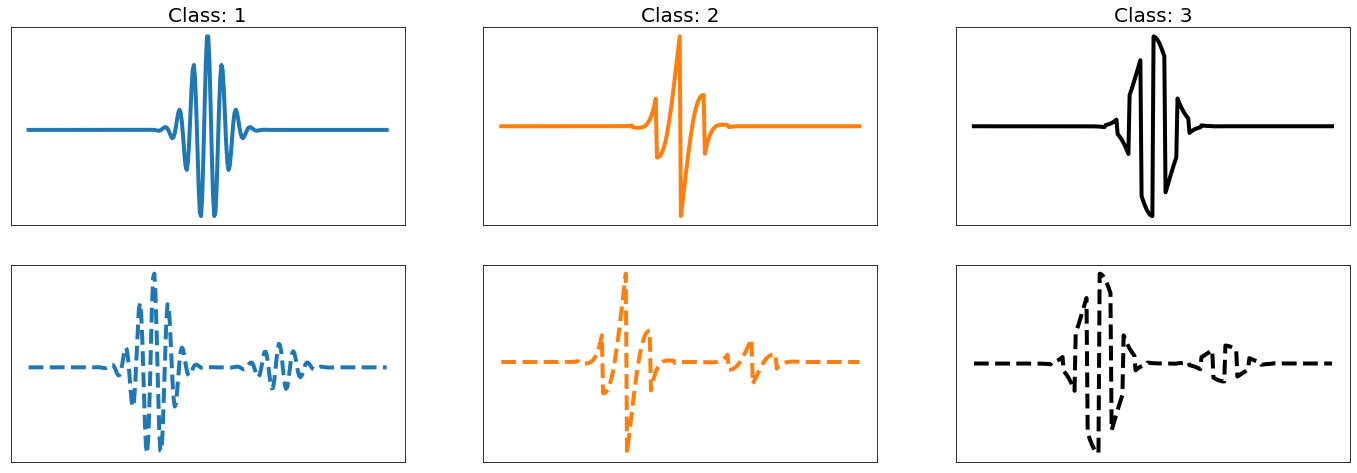

In [15]:
N = 300  # number of discrete samples per signal

## Define a set of signals
t = np.linspace(0.,1.,N)

s_template = []

s_template.append(signal_gabor_phi1(t))
s_template.append(signal_gabor_phi2(t))

s_template.append(signal_sawtooth_phi1(t))
s_template.append(signal_sawtooth_phi2(t))

s_template.append(signal_square_phi1(t))
s_template.append(signal_square_phi2(t))

num_classes = len(s_template)//2

## Plotting
lw = 4.0
fig, ax = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(24,2*4))

ax[0,0].plot(t,s_template[0],'tab:blue',lw=lw)
ax[0,0].set_title("Class: 1",fontsize=20)
ax[0,0].set_yticks([])
ax[0,0].set_xticks([])

ax[0,1].plot(t,s_template[2],'tab:orange',lw=lw)
ax[0,1].set_title("Class: 2",fontsize=20)
ax[0,1].set_yticks([])
ax[0,1].set_xticks([])

ax[0,2].plot(t,s_template[4],'k',lw=lw)
ax[0,2].set_title("Class: 3",fontsize=20)
ax[0,2].set_yticks([])
ax[0,2].set_xticks([])

ax[1,0].plot(t,s_template[1],'tab:blue',ls='--',lw=lw)
ax[1,0].set_yticks([])
ax[1,0].set_xticks([])

ax[1,1].plot(t,s_template[3],'tab:orange',ls='--',lw=lw)
ax[1,1].set_yticks([])
ax[1,1].set_xticks([])

ax[1,2].plot(t,s_template[5],'k',ls='--',lw=lw)
ax[1,2].set_yticks([])
ax[1,2].set_xticks([])

plt.show()

### Define $g(t)$ to generate confounds, i.e., $s_g = g's\circ g$

In [16]:
def g_function_gaussian_mix(x,centers, widths, scales):
    X = np.zeros(len(x))
    for center, width, scale in zip(centers, widths, scales):
        X = X + scale * np.exp(-(x - center) * (x - center) * width)
    X/=X.sum()
    return X

### Generate confounds for training set

In [17]:
num_classes = len(s_template)//2

# generate confounds
L_slope = 10 # number of slope variations
L_shift = 10
s_conf = []
slope_array = np.random.uniform(0.85, 1.15, L_slope) #np.linspace(0.96,1.04,L_slope)
shift_array = np.random.uniform(-0.09,0.09,L_shift) #np.linspace(-0.01,0.01,L_shift)

x_train = []
y_train = []
t_train = []
tp_train = []
coeff = np.zeros(5)
for k in range(num_classes):
    for tmp in range(2):
        Nc = 0
        tmp_ind = 2*k + tmp
        s_conf = []
        y_conf = []
        t_conf = []
        for i_slope in range(L_slope):
            for i_shift in range(L_shift):
                nn = random.randint(2,10)
                centers = np.random.normal(0.5, 0.2, nn)
                widths = np.random.uniform(10.0, 50.0, nn)
                coeffs = np.random.uniform(0.1, 1.0, nn)
                coeffs /= coeffs.sum()

                gm = g_function_gaussian_mix(t,centers, widths, coeffs)

                slope = slope_array[i_slope]
                shift = shift_array[i_shift]

                g = np.cumsum(gm)*slope+shift
                dt = np.gradient(t)
                g_prime = np.gradient(g)/dt
                t_conf.append(g)
                
                if tmp_ind==0:
                    sc =  g_prime*signal_gabor_phi1(g) 
                elif tmp_ind==1:
                    sc =  g_prime*signal_gabor_phi2(g) 
                elif tmp_ind==2:
                    sc =  g_prime*signal_sawtooth_phi1(g) 
                elif tmp_ind==3:
                    sc =  g_prime*signal_sawtooth_phi2(g) 
                elif tmp_ind==4:
                    sc =  g_prime*signal_square_phi1(g) 
                elif tmp_ind==5:
                    sc =  g_prime*signal_square_phi2(g) 
                s_conf.append(sc)
                y_conf.append(k)
                Nc = Nc+1
        x_train.append(np.stack(s_conf, axis=0))
        y_train.append(np.stack(y_conf, axis=0))
        t_train.append(np.stack(t_conf, axis=0))
print(len(x_train))
print(y_train[0].shape)

6
(100,)


### Generate confounds for testing set

In [18]:
# generate confounds
L_slope = 10 # number of slope variations
L_shift = 5
s_conf = []
slope_array = np.random.uniform(0.85, 1.15, L_slope) #np.linspace(0.96,1.04,L_slope)
shift_array = np.random.uniform(-0.09,0.09,L_shift) #np.linspace(-0.01,0.01,L_shift)

s_conf = []
y_conf = []
t_conf = []
coeff = np.zeros(5)
for k in range(num_classes):
    for tmp in range(2):
        tmp_ind = 2*k + tmp
        for i_slope in range(L_slope):
            for i_shift in range(L_shift):
                nn = random.randint(2,10)
                centers = np.random.normal(0.5, 0.2, nn)
                widths = np.random.uniform(10.0, 50.0, nn)
                coeffs = np.random.uniform(0.1, 1.0, nn)
                coeffs /= coeffs.sum()

                gm = g_function_gaussian_mix(t,centers, widths, coeffs)

                slope = slope_array[i_slope]
                shift = shift_array[i_shift]

                g = np.cumsum(gm)*slope+shift
                dt = np.gradient(t)
                g_prime = np.gradient(g)/dt
                t_conf.append(g)
                if tmp_ind==0:
                    sc =  g_prime*signal_gabor_phi1(g) 
                elif tmp_ind==1:
                    sc =  g_prime*signal_gabor_phi2(g) 
                elif tmp_ind==2:
                    sc =  g_prime*signal_sawtooth_phi1(g) 
                elif tmp_ind==3:
                    sc =  g_prime*signal_sawtooth_phi2(g) 
                elif tmp_ind==4:
                    sc =  g_prime*signal_square_phi1(g) 
                elif tmp_ind==5:
                    sc =  g_prime*signal_square_phi2(g)  
                s_conf.append(sc)
                y_conf.append(k)
x_test = np.stack(s_conf, axis=0)
y_test = np.stack(y_conf, axis=0)
t_test = np.stack(t_conf, axis=0)

print(x_test.shape)
print(y_test.shape)

(300, 300)
(300,)


### Choose number of training samples per class
In this example we have used 16 randomly chosen samples per class to train the model. The samples were chosen in such a way that the training set contains an equal number of samples generated from each template.

In [19]:
n_samples_perclass = 64          ## number of training samples per class
n_counts = x_train[0].shape[0]   ## number of total samples per template
x_train_sub = []
y_train_sub = []

for l in range(len(x_train)):    ## iterate over set from each template
    data = x_train[l]
    y_data = y_train[l]
    index_array = random.sample(range(n_counts), n_samples_perclass//2)
    for i in range(len(index_array)):
        x_train_sub.append(data[index_array[i]])
        y_train_sub.append(y_data[index_array[i]])
x_train_sub = np.stack(x_train_sub,axis = 0)
y_train_sub = np.stack(y_train_sub,axis = 0)

### Create an instance for SCDT_NLS class

In [20]:
scdt_nls_obj = SCDT_NLS(num_classes)

### Training Phase

In [21]:
scdt_nls_obj.fit(x_train_sub, y_train_sub, no_local_enrichment=False)

+++++++++++ Training Phase +++++++++++

Calculating SCDTs for training data ...

Tune parameters using validation set ...



### Testing Phase

In [22]:
from sklearn.metrics import accuracy_score

preds = scdt_nls_obj.predict(x_test)

print('+++++++++++ Result +++++++++++')
print('\nTest accuracy: {}%'.format(100*accuracy_score(y_test, preds)))

+++++++++++ Testing Phase +++++++++++

Calculating SCDTs for testing data ...

Apply NLS algorithm in SCDT domain

+++++++++++ Result +++++++++++

Test accuracy: 100.0%
